# 1 - Import

In [1]:
# Import Libraries
import glob, pylab, pandas as pd
import pydicom, numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pylab as plt
import os
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import os
import json

import cv2

from keras import layers
from keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import Constant
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.python.ops import array_ops
  
from keras import backend as K
import tensorflow as tf

In [2]:
!ls ../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection
PATH = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection'

stage_2_sample_submission.csv  stage_2_test  stage_2_train  stage_2_train.csv


# 2 - Load Data

In [3]:
# Load Training Information (Labels and IDs)
data = pd.read_csv('../input/rsna-intracranial-hemorrhage-detection//rsna-intracranial-hemorrhage-detection/stage_2_train.csv')
data = data.drop_duplicates()


In [4]:
# Images Example
input_path = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/"
data_path = input_path + 'stage_2_train/'
data_list = listdir(data_path) 

print('2 images')
print(data_list[:2]) # Print the first 2 


2 images
['ID_27a354d42.dcm', 'ID_9ef779a18.dcm']


In [5]:
print('Number of images:', len(data_list))

Number of images: 752803


In [6]:
data.Label.value_counts() #Shows the number of training images with a given label

0    4260576
1     256242
Name: Label, dtype: int64

# 3 - Check Images

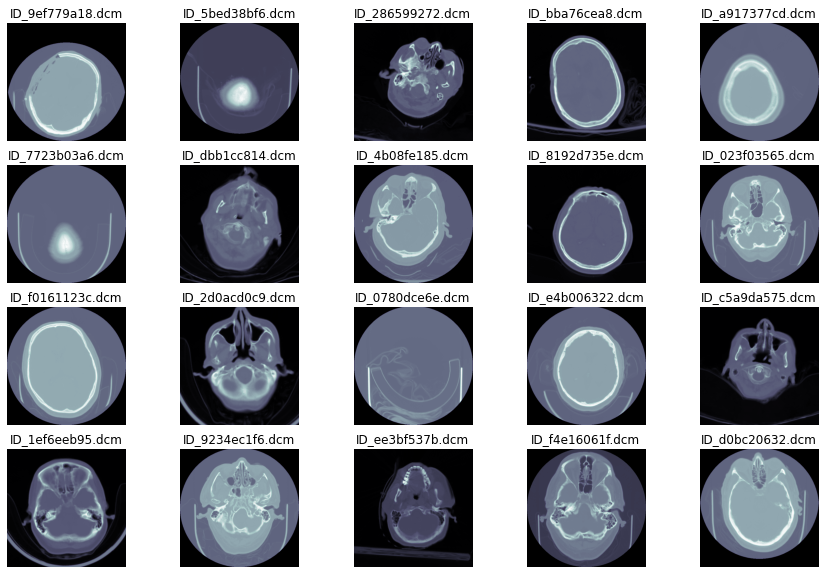

In [7]:
#Display some examples of the images
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 4
for i in range(1, columns*rows +1):
    ds = pydicom.dcmread(data_path + data_list[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    plt.title(data_list[i])
    plt.axis('off')
    fig.add_subplot

# 4 - Modify Table

In [8]:
data['Sub_type'] = data['ID'].str.split("_", n = 3, expand = True)[2]
data['PatientID'] = data['ID'].str.split("_", n = 3, expand = True)[1]
data['filename'] = data['ID'].str.split("_",n = 3, expand = True)[0] + "_" + data['ID'].str.split("_", n = 3, expand = True)[1] + ".png"
data.head()

,ID,Label,Sub_type,PatientID,filename
0,ID_12cadc6af_epidural,0,epidural,12cadc6af,ID_12cadc6af.png
1,ID_12cadc6af_intraparenchymal,0,intraparenchymal,12cadc6af,ID_12cadc6af.png
2,ID_12cadc6af_intraventricular,0,intraventricular,12cadc6af,ID_12cadc6af.png
3,ID_12cadc6af_subarachnoid,0,subarachnoid,12cadc6af,ID_12cadc6af.png
4,ID_12cadc6af_subdural,0,subdural,12cadc6af,ID_12cadc6af.png


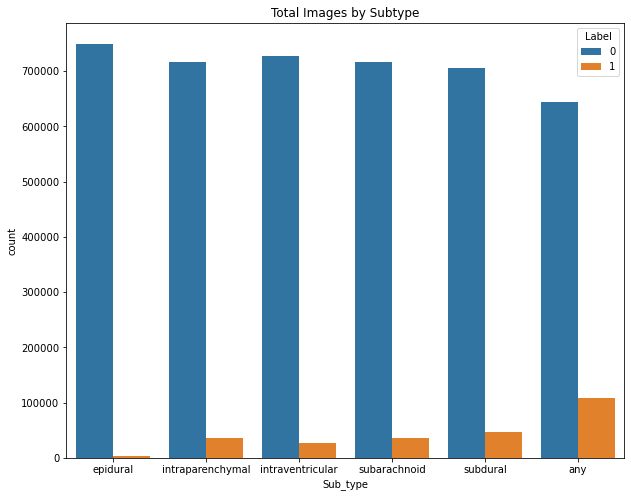

In [9]:
fig=plt.figure(figsize=(10, 8))
sns.countplot(x="Sub_type", hue="Label", data=data)
plt.title("Total Images by Subtype")
plt.show()



In [10]:
count_series = data.groupby(['Sub_type', 'Label']).size()
count_series

Sub_type          Label
any               0        644870
                  1        107933
epidural          0        749658
                  1          3145
intraparenchymal  0        716685
                  1         36118
intraventricular  0        726598
                  1         26205
subarachnoid      0        717128
                  1         35675
subdural          0        705637
                  1         47166
dtype: int64

# 5 - Extract Portion of Training Data

In [11]:

#SELECTING DATA: METHOD 1 
#We aquire 150000 patient IDs and split this into 80% training and 20% testing. 

#note: this is not ensuring an even split of sub types and labels 
np.random.seed(1749)

subset_list = np.random.choice(np.unique(data_list), 150000) #choosing to only use 150000 IDs for both training and testing
print(subset_list)
# partition the data into training and testing splits 
(train, test) = train_test_split(subset_list,test_size=0.20, random_state=42) 

train_set = data[data.filename.apply(lambda x: x.replace('.png', '.dcm')).isin(train)]  
test_temp = data[data.filename.apply(lambda x: x.replace('.png', '.dcm')).isin(test)]
test_set = pd.DataFrame(test_temp.filename.unique(), columns=['filename'])

test_set.head(10)
train_set.head()
train = np.array([name.replace('png', 'dcm') for name in train])
test = np.array([name.replace('png', 'dcm') for name in test])
train_set.head()

['ID_1995e13cf.dcm' 'ID_10b2d92f2.dcm' 'ID_1b295cd6f.dcm' ...
 'ID_d5793ff56.dcm' 'ID_a783a6d29.dcm' 'ID_1ae2819f4.dcm']


,ID,Label,Sub_type,PatientID,filename
24,ID_4d9209c7c_epidural,0,epidural,4d9209c7c,ID_4d9209c7c.png
25,ID_4d9209c7c_intraparenchymal,0,intraparenchymal,4d9209c7c,ID_4d9209c7c.png
26,ID_4d9209c7c_intraventricular,0,intraventricular,4d9209c7c,ID_4d9209c7c.png
27,ID_4d9209c7c_subarachnoid,0,subarachnoid,4d9209c7c,ID_4d9209c7c.png
28,ID_4d9209c7c_subdural,0,subdural,4d9209c7c,ID_4d9209c7c.png


In [12]:
"""
## SELECTING DATA: METHOD 2
# We should try to use all 800 of the images that have epidural = 1 because its lacking in training data
# we want an even distribution of subtypes so no bias 
np.random.seed(1749)
epi_data= data[data['Sub_type']== 'epidural'][data['Label']==1]
epi_list = epi_data.filename.to_list() #extracted list of filenames where epidural label is 1 
epi_list = np.random.choice(np.unique(epi_list), 800) #choosing 800 random filenames

other_data= data[data['Sub_type']== 'epidural'][data['Label']==0]
other_list = other_data.filename.to_list() #extracted list of filenames where epidural label is 0
other_list = np.random.choice(np.unique(other_list), 9200) #choosing to only use 9200 IDs for both training and testing
subset_list = [*other_list, *epi_list]
subset_data = data[data.filename.isin(subset_list)]

# partition the data into training and testing splits 
(train, test) = train_test_split(subset_list,test_size=0.20, random_state=42) 

train_set = data[data.filename.isin(train)]  
test_temp = data[data.filename.isin(test)]
test_set = pd.DataFrame(test_temp.filename.unique(), columns=['filename'])

train = np.array([name.replace('png', 'dcm') for name in train])
test = np.array([name.replace('png', 'dcm') for name in test])
train_set.head()

fig=plt.figure(figsize=(10, 8))
sns.countplot(x="Sub_type", hue="Label", data=subset_data)
plt.title("All Images by Subtype")
plt.show()

fig=plt.figure(figsize=(10, 8))
sns.countplot(x="Sub_type", hue="Label", data=train_set)
plt.title("Training Images by Subtype")
plt.show()

count_series = subset_data.groupby(['Sub_type', 'Label']).size()
count_series

"""

'\n## SELECTING DATA: METHOD 2\n# We should try to use all 800 of the images that have epidural = 1 because its lacking in training data\n# we want an even distribution of subtypes so no bias \nnp.random.seed(1749)\nepi_data= data[data[\'Sub_type\']== \'epidural\'][data[\'Label\']==1]\nepi_list = epi_data.filename.to_list() #extracted list of filenames where epidural label is 1 \nepi_list = np.random.choice(np.unique(epi_list), 800) #choosing 800 random filenames\n\nother_data= data[data[\'Sub_type\']== \'epidural\'][data[\'Label\']==0]\nother_list = other_data.filename.to_list() #extracted list of filenames where epidural label is 0\nother_list = np.random.choice(np.unique(other_list), 9200) #choosing to only use 9200 IDs for both training and testing\nsubset_list = [*other_list, *epi_list]\nsubset_data = data[data.filename.isin(subset_list)]\n\n# partition the data into training and testing splits \n(train, test) = train_test_split(subset_list,test_size=0.20, random_state=42) \n\ntra

In [13]:
labelCount = train_set.Label.value_counts() #Shows the number of training images with a given label
print(labelCount)
labelRatio = labelCount[0]/labelCount[1]
print(labelRatio) #How many class labels "0" there are for every class label "1"

class_weight = {0: 1.,
                1: labelRatio}

                

0    628872
1     37440
Name: Label, dtype: int64
16.796794871794873


In [14]:
pivot_df = train_set[['Label', 'filename', 'Sub_type']].drop_duplicates().pivot(
    index='filename', columns='Sub_type', values='Label').reset_index()
pivot_df.head()

Sub_type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000178e76.png,0,0,0,0,0,0
1,ID_0001f7f62.png,0,0,0,0,0,0
2,ID_0002108bd.png,0,0,0,0,0,0
3,ID_00042829c.png,1,0,0,1,0,0
4,ID_00042bee4.png,0,0,0,0,0,0


# 6 - Rescale, Resize, Convert to PNG

In [15]:
def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    
    if rescale:
        # Extra rescaling to 0-1, not in the original notebook
        img = (img - img_min) / (img_max - img_min)
    return img
    
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

def save_and_resize(filenames, load_dir):    
    save_dir = '/kaggle/tmp/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for filename in tqdm(filenames):
        path = load_dir + filename
        new_path = save_dir + filename.replace('.dcm', '.png')
        
        dcm = pydicom.dcmread(path)
        window_center , window_width, intercept, slope = get_windowing(dcm)
        img = dcm.pixel_array
        img = window_image(img, window_center, window_width, intercept, slope)
        
        resized = cv2.resize(img, (224, 224))
        res = cv2.imwrite(new_path, resized*255) #added the *255 
        

In [16]:
save_and_resize(filenames=train, load_dir=data_path)
save_and_resize(filenames=test, load_dir=data_path)

100%|██████████| 30000/30000 [08:19<00:00, 60.05it/s]


# 7 - Data Generator

In [17]:
BATCH_SIZE = 64 

def create_datagen():
    return ImageDataGenerator(validation_split=0.15)

def create_test_gen():
    return ImageDataGenerator().flow_from_dataframe(
        test_set,
        directory='/kaggle/tmp/',
        x_col='filename',
        class_mode=None,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

def create_flow(datagen, subset):
    return datagen.flow_from_dataframe(
        pivot_df, 
        directory='/kaggle/tmp/',
        x_col='filename', 
        y_col=['any', 'epidural', 'intraparenchymal', 
               'intraventricular', 'subarachnoid', 'subdural'],
        class_mode='other',
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        subset=subset
    )

# Using original generator
data_generator = create_datagen()
train_gen = create_flow(data_generator, 'training')
val_gen = create_flow(data_generator, 'validation')
test_gen = create_test_gen()

Found 94395 validated image filenames.
Found 16657 validated image filenames.
Found 29402 validated image filenames.


Loss Function 

In [18]:
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

# 8 - Train Model

In [19]:
densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [28]:
"""
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(6, activation='sigmoid', 
#                            bias_initializer=Constant(value=-5.5)))
    model.add(layers.Dense(6, activation='sigmoid'))
    
    model.compile(
#         loss=focal_loss,
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.001),
        metrics=['accuracy']
    )
    
    return model
"""
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        #loss=binary_focal_loss(),
        optimizer=Adam(lr=0.001),
        metrics=['acc', tf.keras.metrics.AUC()]
    )
        

    return model

In [29]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 7,043,654
Trainable params: 6,960,006
Non-trainable params: 83,648
_________________________________________________________________


In [30]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

total_steps = train.shape[0] / BATCH_SIZE

history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,  # originally 2000
    validation_data=val_gen,
    validation_steps=total_steps * 0.15,
    callbacks=[checkpoint],
    epochs=70, #used to be 5
    class_weight=class_weight
)





Epoch 1/70
100/100 [==============================] - 75s 749ms/step - loss: 0.1423 - acc: 0.5416 - auc_1: 0.9168 - val_loss: 0.1133 - val_acc: 0.7608 - val_auc_1: 0.9403
Epoch 2/70
100/100 [==============================] - 75s 749ms/step - loss: 0.0915 - acc: 0.5991 - auc_1: 0.9585 - val_loss: 0.1104 - val_acc: 0.8314 - val_auc_1: 0.9472
Epoch 3/70
100/100 [==============================] - 72s 716ms/step - loss: 0.0901 - acc: 0.6314 - auc_1: 0.9591 - val_loss: 0.1343 - val_acc: 0.4575 - val_auc_1: 0.9196
Epoch 4/70
100/100 [==============================] - 74s 742ms/step - loss: 0.0912 - acc: 0.6642 - auc_1: 0.9615 - val_loss: 0.1501 - val_acc: 0.6497 - val_auc_1: 0.9016
Epoch 5/70
100/100 [==============================] - 75s 750ms/step - loss: 0.0849 - acc: 0.6523 - auc_1: 0.9664 - val_loss: 0.1010 - val_acc: 0.9659 - val_auc_1: 0.9520
Epoch 6/70
100/100 [==============================] - 71s 708ms/step - loss: 0.0865 - acc: 0.6714 - auc_1: 0.9634 - val_loss: 0.1104 - val_acc: 0

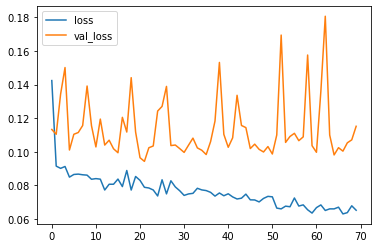

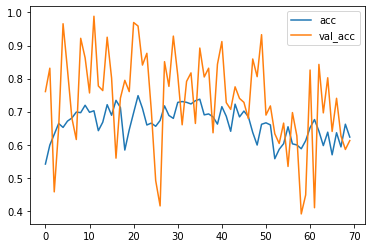

In [31]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)
    

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

# 9 - Predict 

In [32]:
model.load_weights('model.h5')
y_test = model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

460/460 [==============================] - 66s 144ms/step


In [33]:
# Append the output predicts in the wide format to the y_test
test_set2= test_set.join(pd.DataFrame(y_test, columns=[
    'any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural'
]))

# Unpivot table, i.e. wide (N x 6) to long format (6N x 1)
test_set2 = test_set2.melt(id_vars=['filename'])

# Combine the filename column with the variable column
test_set2['ID'] = test_set2.filename.apply(lambda x: x.replace('.png', '')) + '_' + test_set2.variable
test_set2['Label'] = test_set2['value']

test_set3= pd.DataFrame(test_set2, columns = ['ID', 'Label']) 
test_set3.to_csv('test_results.csv', index=False)

# 9 - Evaluate Test Results 

In [34]:
ground_truth = test_temp.sort_values(by=['ID'])
predictions = test_set3.sort_values(by=['ID'])
predictions.head()

,ID,Label
21999,ID_00042bee4_any,0.015260
51401,ID_00042bee4_epidural,0.000293
80803,ID_00042bee4_intraparenchymal,0.000534
110205,ID_00042bee4_intraventricular,0.000036
139607,ID_00042bee4_subarachnoid,0.003929


In [35]:
from sklearn.metrics import accuracy_score, confusion_matrix

yhat = predictions.Label
# round probabilities to class labels
yhat = yhat.round()
# calculate accuracy
acc = accuracy_score(ground_truth.Label, yhat)
print("Accuracy: ", acc)

cm = confusion_matrix(ground_truth.Label, yhat)
tn, fp, fn, tp = cm.ravel()

rec = tp / (tp + fn)
prec  = tp / (tp + fp)
spec = tn / (tn + fp)
f1 = tp / (tp + 0.5*(fp + fn))
print("Confusion Matrix: ", cm)
print("TP: ", tp)
print("TN: ", tn)
print("FP: ", fp)
print("FN: ", fn)

print("RECALL: ", rec)
print("PRECISION: " ,prec)
print("SPECIFICITY: ", spec)
print("F1 SCORE: ", f1)

Accuracy:  0.9692991406480285
Confusion Matrix:  [[165736    920]
 [  4496   5260]]
TP:  5260
TN:  165736
FP:  920
FN:  4496
RECALL:  0.5391553915539156
PRECISION:  0.8511326860841424
SPECIFICITY:  0.9944796466973886
F1 SCORE:  0.660140562248996
